# First simple web-map with Folium


**Date**: 22.03.2023

**Course**: Methods of Spatial Analysis. Advanced Level. // HSE, Moscow, spring 2023


## 1. Import libraries


In [1]:
## For working with dataframes

import pandas as pd
import geopandas as gpd
import folium

from shapely import geometry


## 2.Read data from a geojson file


In [3]:
data = gpd.read_file('gpkg/okn_pnt.gpkg')
data_poly = gpd.read_file('gpkg/okn_ply.gpkg')
data_poly.head()

,full_id,osm_id,building,name,addr:housenumber,fid_2,field_1,№\nп/п,Регистр.\n№ в\nсписках,Наименование по решению,Датировка,Материал,Категория охраны,Категория памятника,Адрес по решениям по постановлениям,Адрес,address,Latitude,Longitude,geometry
0,r15966824,15966824,museum,Иркутский областной художественный музей им. В...,5,265,264.0,242,N\n381410076\n590005,Здание областного художественного музея и авиа...,(1907 г.; 1803 г.),кирпич,"ГО регион., реш. обл. N 294 от 24.06.80 г., пр...",региональный,"Иркутская область, г. Иркутск, ул. Ленина, 5","Ленина ул., 5, лит.А, А1, А2; Ленина ул., 5-а,...","Иркутская область, г. Иркутск, Ленина ул., 5, ...",52.283958,104.281442,"MULTIPOLYGON (((450979.112 5792882.193, 450978..."
1,w80238968,80238968,yes,None,6,376,375.0,,N\n381710921\n630025,Духовная консистория,кон.ХVIII в.; ХIХ в.,кирпич,"ГО регион., реш. обл. N 73 от 22.02.90 г., при...",региональный,"Иркутская область,г. Иркутск, ул. Нижне- Набер...","Нижняя Набережная ул., 8, лит.А, А1","Иркутская область, г. Иркутск, Нижняя Набережн...",52.292391,104.284703,"MULTIPOLYGON (((451306.931 5793864.077, 451309..."
2,w80238973,80238973,yes,Дом Советов,1А,263,262.0,240,N\n421410027\n04005,Губернское казначейство,1853 г.; 1880-е гг.; 1900-1902,кирпич,"ГО регион., реш. обл. N 73 от 22.02.90 г., при...",региональный,"Иркутская область, г. Иркутск, ул. Ленина, 1","Ленина ул., 1, лит.А","Иркутская область, г. Иркутск, Ленина ул., 1, ...",52.290139,104.279331,"MULTIPOLYGON (((450906.201 5793561.363, 450905..."
3,w80238976,80238976,school,Специальная (коррекционная) школа №10 г. Иркутска,7,666,665.0,555,,Городское начальное училище им. Кладищевой,1915-1916 гг.,кирпич,"ГО регион., приказ № 223- спр от 22.09.2020",региональный,"Иркутская область, г. Иркутск, ул. Чкалова, 7","ул. Чкалова, 7","Иркутская область, г. Иркутск, ул. Чкалова, 7",52.285820,104.269359,"MULTIPOLYGON (((450150.000 5793066.111, 450131..."
4,w80240752,80240752,yes,None,4,665,664.0,554,,Дом причта Троицкой церкви,1903 г.,дерево,"Го регион., приказ о включении в реестр N 178-...",региональный,"Иркутская область, г. Иркутск, ул. Чкалова, 4","Чкалова ул., 4","Иркутская область, г. Иркутск, Чкалова ул., 4",52.285566,104.269674,"MULTIPOLYGON (((450172.224 5793039.613, 450165..."


#### \* clear data and save only valuable attributes

(here is an example how to drop fields, you may need to delete more/less depends, you may choose another way to remove attributes )


In [4]:
data = data.drop(columns=['Тип объекта культурного наследия', 'текстовое описание границ' ])

KeyError: "['Тип объекта культурного наследия', 'текстовое описание границ'] not found in axis"

## 2.Create Grid (fishnet)

- to plot concentration of cultural heritage (or any other point layer) with a choropleth map


#### 2.1. Check CRS of current data and decide do you need to reproject it or not?


- here is an example of reading the current crs and reprojecting geodataframe to another crs (you need to choose by yourself do you need it or not), but I'd rather reccommend to use UTM-zone, when you plot data with folium it is better to choose Web Mercator (EPSG:3857)


In [10]:
print(data.crs.name)

#if you need to reproject you can use .to_crs method
data = data.to_crs("EPSG:32648")
data_poly = data_poly.to_crs("EPSG:32648")


WGS 84 / UTM zone 48N


#### 2.2. Get the extent of the data


In [6]:
total_bounds = data.total_bounds
minX, minY, maxX, maxY = total_bounds

#### 2.3. Select cell-size


- what are the units?


In [7]:
square_size = 500

#### 2.4. Create fishnet


- you may choose another way to create using QGIS and read prepared data here


In [13]:
grid_cells = []
x, y = (minX, minY)
geom_array = []

while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size


fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32648')
fishnet['id'] = fishnet.index

- save final grid to file if you need it


In [8]:
#fishnet.to_file('grid.gpkg')

## 3. Count Points in Polygon


#### 3.1. Merge fishnet and your points data to count them in polygons


In [14]:
merged = gpd.sjoin(data, fishnet, how='left', predicate='within')
merged['n'] = 1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
fishnet.loc[dissolve.index, 'n'] = dissolve.n.values


#### 3.2. Plot the result


- we do it just to check the final result, no any other practical need


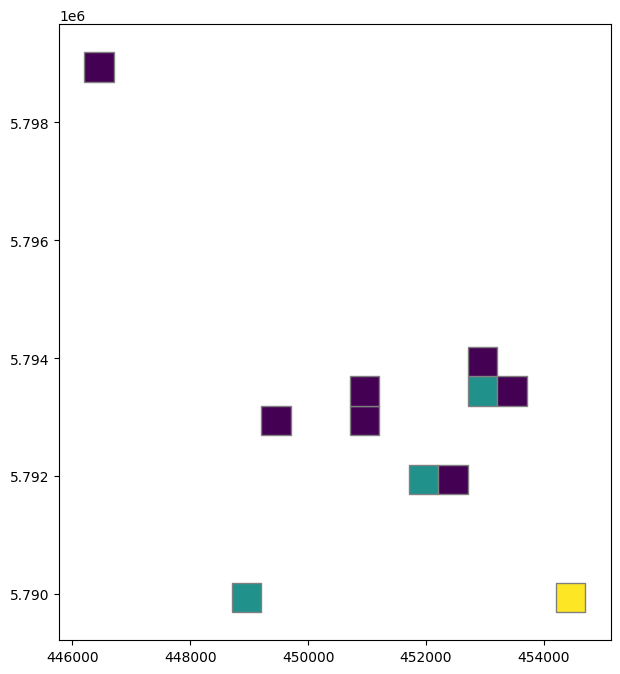

In [15]:
ax = fishnet.plot(column='n', figsize=(12, 8), cmap='viridis', scheme='natural_breaks', k=3, edgecolor="grey")


## 3. Create Web-map


#### 3.1 Map Settings

- carefully look at the function, try to understand what each variable stands for


In [16]:
data = data.to_crs('EPSG:4326')
m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


C:\Users\fobos\AppData\Local\Temp\ipykernel_4520\440777897.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[data.centroid.y.mean(), data.centroid.x.mean()], zoom_start=12,  tiles="cartodb positron", control_scale=True)


#### 3.2 Explore the map box. Do we need any changes?


In [17]:
m

#### 3.3 Create a Choropleth map based on a fishnet


In [18]:
folium.Choropleth(
    geo_data=fishnet,
    data=fishnet,
    columns=['id', 'n'],
    fill_color='YlGnBu',
    fill_opacity = 0.5,
    key_on='id',
    nan_fill_opacity=0,
   line_color = "#0000",
   legend_name="amount of heritage sites",
   name='Heritage Sites Concentration'
).add_to(m)

- look a the map


In [19]:
m

#### 3.4 Add heritage buildings with tooltips


- try to color heritage buildings based on their conservation status


In [27]:
#colors = ["orange", "yellow", "green", "blue"]
#categories = data_poly['Категория историко-культурного значения'].unique()

folium.GeoJson(
    data_poly,
    name="Heritage buildings",
    tooltip=folium.GeoJsonTooltip(fields=["r_name"]),
    popup=folium.GeoJsonPopup(fields=['r_name']),
    style_function=lambda x: {
        "fillColor": 'yellow'
    },
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=True,
    show=False,
).add_to(m)


- look a the map


In [28]:
m

AssertionError: The field r_name is not available in the data. Choose from: ('full_id', 'osm_id', 'building', 'name', 'addr:housenumber', 'fid_2', 'field_1', '№\nп/п', 'Регистр.\n№ в\nсписках', 'Наименование по решению', 'Датировка', 'Материал', 'Категория охраны', 'Категория памятника', 'Адрес по решениям по постановлениям', 'Адрес', 'address', 'Latitude', 'Longitude').

#### 3.5 Add points cluster


In [24]:
from folium.plugins import MarkerCluster

In [25]:
marker_cluster = MarkerCluster(name='Heritage Sites')
mc1= folium.plugins.FeatureGroupSubGroup(marker_cluster, 'Heritage Sites')
m.add_child(marker_cluster)
m.add_child(mc1)
mc1.add_child(folium.GeoJson(data.to_json(), embed=False, show=False))


In [26]:
m

AssertionError: The field r_name is not available in the data. Choose from: ('full_id', 'osm_id', 'building', 'name', 'addr:housenumber', 'fid_2', 'field_1', '№\nп/п', 'Регистр.\n№ в\nсписках', 'Наименование по решению', 'Датировка', 'Материал', 'Категория охраны', 'Категория памятника', 'Адрес по решениям по постановлениям', 'Адрес', 'address', 'Latitude', 'Longitude').

#### 3.6 Add different widgets to map


- import plugins


In [28]:
from folium.plugins import MousePosition
from folium.plugins import Fullscreen

In [29]:
folium.LayerControl().add_to(m)

In [30]:
MousePosition().add_to(m)
Fullscreen(
    position="bottomright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(m)


In [ ]:
m

## 4. Save map to index.html file and prepare to publish it


In [ ]:
m.save("index.html")